# Example F-M estimation using a multi-modelling approach: Merapi

Determining the relationship between frequency and magnitude of volcanism is an important element of long-term volcanic hazard risk assessment. However, there is substantial uncertainty when estimating potential future eruption frequency and style, particularly in regions where eruption history data are relatively poorly constrained. To derive frequency-magnitude relationships in such environments, previous approaches have used analogues, typically defined as a function of the volcano morphology.

Southeast Asia is a particularly active volcanic region, with over 170 volcanoes considered active in the Holocene. This high density of potentially active volcanoes coupled with relatively high population density means that Southeast Asia is one of the highest volcanic risk regions in the world (Loughlin et al. 2015). However, the volcanic record in the region is relatively limited (Simkin and Siebert 1994). Consequently, there is considerable uncertainty associated with the frequency-magnitude of volcanic eruptions at volcanoes in the region (Jenkins et al. 2012; Mead and Magill 2014; Whelley et al. 2015).

Bayesian analysis has been utilised as a method for assessing frequency-magnitude relationships for volcanoes (e.g. Sheldrake 2014; Sheldrake and Carricchi 2017). However, such approaches are still sensitive to the choice of prior used in the Bayesian update. Ensemble modelling, where multiple different models are combined to produce a single forecast, has been put forward as a useful approach in such situations.

In this notebook, we present an example case study to derive frequency-magnitude relationships for volcanoes in Southeast Asia. The proposed approach uses a Bayesian updating method and integrates different models for classifying analogues using model averaging.

## pymc3
Numerous probabilistic programming languages and systems have been developed in the last few decades. We use PyMC3 probabilistic programming package (Salvatier et al. 2016) for python to conduct Bayesian analysis. The benefit of using PyMC3 is that it is open-source and provides a simple and intuitive integration into the python programming language, offering flexibility for interacting with existing python code (Salvatier et al. 2016).

## Libraries and functions
Below are the libraries and functions used

In [1]:
#libraries
import pymc3 as pm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import beta
import arviz
import csv
import warnings
warnings.filterwarnings('ignore')

#Functions
from Functions import assign_A1_classification
from Functions import get_complete_record
from Functions import calc_mean_annual_frequency_analogue
from Functions import calc_std_annual_frequency_analogue
from Functions import calc_relative_probability
from Functions import get_VEI_eruptions_count
from Functions import get_observed_eruption_rate
from Functions import get_observed_relative_frequency
from Functions import get_freq_mag_dirichlet
from Functions import set_analogue_eruption_rate
from Functions import get_FM_relationship
from Functions import get_observed_eruption_rate_full_record
from Functions import get_observed_relative_frequency_full_record
from Functions import get_master_csv
from Functions import save_plot
#from Functions import get_model_trace
from Functions import get_model_average

## Defining the volcano of interest
Next, we set two variables called 'year' and 'volc_num'. The 'year' variable is the year of the GVP eruption database that is used in the analysis. In our case, we've used the GVP 4.8.5 that was downloaded in January 2020. Given that the last full year of data in the database was 2019, we use this as the 'year' variable. The volc_num is the GVP eruption number for the volcano of interest. In this example, we use the GVP number for Merapi. 

In [2]:
year = 2019
volc_num = 263250

## Assigning analogue classes
Since Southeast Asia has numerous volcanoes with poor eruption records, but are considered to be potentially active, there is a need to find a transparent and robust methodologies to assess how likely these volcanoes are to eruption for volcanic hazard assessment. Analogue volcanoes are typically used to assess frequency-magnitude relationships for volcanoes with poor eruption records, under the assumption that volcanoes will behave similarly to selected analogues (e.g. Jenkins et al. 2012; Whelley et al. 2015; Sheldrake 2014). Often volcano morphology (e.g. large cone, caldera) is used to define different volcano analogue classifications. However, there is no standardised approach to selecting volcano analogues. For example, Jenkins et al. (2012) utilised the Primary Volcano Type classification from the GVP, whereas Whelley et al. (2015) used a desktop geomorphological investigation using remotely sensed imagery and consideration of the recent activity at the volcano (e.g. gas emissions and recent eruptive behaviour) to classify analogues. These two different approaches to analogue classification can result in different estimates for frequency-magnitude at volcanoes. 

In this work, we use two different analogue classifications systems:
 - [Jenkins et al. (2012)](https://doi.org/10.1007/s00445-012-0627-8) - We will refer to this system as the "A1" classification system
 - [Whelley et al. (2015)](https://doi.org/10.1007/s00445-014-0893-8) - We will refer to this system as the "A2" classification system


### Analogue model 1: Jenkins approach to global analogue frequency-magnitude
Jenkins et al. (2012) developed a methodology to estimate average recurrence intervals for eruptions greater than or equal to Volcanic Explosivity Index (VEI) 4. The methodology uses the eruption history of each volcano and, for data poor volcanoes, the globally averaged eruptive behaviour of analogous volcanoes.

To infer averaged eruptive behaviour across analogous volcanoes, Jenkins et al. (2012) used the Smithsonian Institution classification of volcanoes from the Global Volcanism Program (GVP) volcano database and assigned each volcano to a broad type category (see below table taken from Jenkins et al. 2012 - Table 4). Jenkins et al. (2012) then used the GVP database to determine conditional magnitude probabilities for VEI 4, 5, 6 and 7 relative to eruptions VEI 3 and below, for each volcano category. The globally averaged eruption conditional probabilities were then applied to each volcano of the same category.

| Volcano type category | Smithsonian Institution definition |
| --- | --- |
| Caldera | Caldera, Calderas, pyroclastic shield |
| Large cone | Complex volcano, Complex volcanoes, Compound volcanoes, Somma volcano, Stratovolcano, Stratovolcanoes, Volcanic complex |
| Shield | Shield volcano, Shield volcanoes |
| Lava dome | Lava dome, Lava domes |
| Small cone | Cinder cone, Cinder cones, Cones, Crater rows, Explosion craters, Fissure vent, Fissure vents, Lava cone, Maar, Maars, Pyroclastic cone, Pyroclastic cones, Scoria cones, Tuff cones, Tuff rings, Volcanic field |


### Analogue model 2: Whelley approach to regional analogue frequency-magnitude
Whelley et al. (2015) classified Southeast Asian volcanoes into five groups. Instead of using the GVP classification, they developed a classification framework that integrates morphology, and where known, the eruptive history and degassing style of volcanoes in Southeast Asia (see table below adapted from Figure 2 of Whelley et al. 2015). An important distinction to keep in mind is that the Jenkins approach uses globally averaged behaviour, whilst Whelley uses only volcanoes from Southeast Asia supplemented by the inclusion of some Japanese volcanoes because of the excellent volcano record from Japan.

| Volcano type category | Definition used by Whelley et al. (2015) |
| --- | --- |
| Distributed cones and fields | Field of cinder and spatter cones |
| Large caldera | Crater larger than 5 km |
| Open-vent stratocone | stratovolcanoes that have more than two VEI 1 or 2 eruptions in past decade and average more than 8 emission events per year of 0.8 kt/day of SO2 since 1979 as tabulated by Aerocom and collected by TOMS, COSPEC, and ONEM and classified as open-vent stratocones. |
| Semi-plugged stratocone | Stratocone with a summit crater less than or equal to 2.5 km and has not erupted in the past decade or has insufficient SO2 emissions |
| Well-plugged stratocone | Stratocone with a summit crater greater than or equal to 2.5 km and has not erupted in the past decade or has insufficient SO2 emissions |

### Analogue classification
To assign the analogue classes, we first read in a csv file of the GVP Holocene Volcano list. We then apply the assign_A1_classification function. This function assigns an analogue class to every volcano in the GVP Holocene Volcano list based upon the criteria outlined in the Jenkins et al. 2012 paper. The volcano analogue type is contained within the "Volcano type" column. This assigns Merapi to be a "Large cone" volcano type.

We then read in the A2 analogue system. This assigns analogue classes to all volcanoes in Southeast Asia and Japan. These are based upon the classes assigned in Whelley et al. 2015. We do not re-run the analysis used to derive the classes from Whelley as this requires a lot of manual interpretations. Instead, we use the classes assigned in their supplementary material. This assigns Merapi to be an "Open-vent stratocone" volcano type.  

In [3]:
GVP_volcanoes = pd.read_csv("volcano_list.csv")

# Assign analogues based on the A1 classification system
A1_volcanoes = assign_A1_classification(GVP_volcanoes)
Analogue_volcanoes_A1 = A1_volcanoes
A1_volcanoes # View the dataframe



,Volcano Number,Volcano Name,Volcano type
0,263160,Gunung Putri,Lava dome
1,275090,Lower Chindwin,Small cone
2,263150,Talagabodas,Large cone
3,263292,Malang Plain,Small cone
4,275010,Leizhou Bandao,Small cone
...,...,...,...
1426,390120,Leskov Island,Large cone
1427,390130,Zavodovski,Large cone
1428,390140,Protector Seamounts,NaN
1429,390829,James Ross Island,Shield


In [4]:
# Merapi specifically
A1_volcanoes.loc[A1_volcanoes['Volcano Number'] == 263250]


,Volcano Number,Volcano Name,Volcano type
395,263250,Merapi,Large cone


In [5]:
# Assign analogues based on the A2 classification system

A2_volcanoes = pd.read_csv("Whelley_SEA.csv")
A2_volcanoes = A2_volcanoes[['Volcano Number', 'Volcano Name', 'Volcano type']]
A2_volcanoes

,Volcano Number,Volcano Name,Volcano type
0,260001,NARCONDUM,Semi-plugged stratocone
1,260010,BARREN ISLAND,Open-vent stratocone
2,261020,SEULAWAH AGAM,Semi-plugged stratocone
3,261030,PEUETSAGU,Semi-plugged stratocone
4,261050,BUR NI TELONG,Semi-plugged stratocone
...,...,...,...
252,284030,Kozushima,Semi-plugged stratocone
253,284040,Miyakejima,Semi-plugged stratocone
254,284041,Mikurajima,Semi-plugged stratocone
255,284050,Hachijojima,Semi-plugged stratocone


In [6]:
# Merapi specifically
Analogue_volcanoes_A2 = A2_volcanoes
A2_volcanoes.loc[A2_volcanoes['Volcano Number'] == 263250]


,Volcano Number,Volcano Name,Volcano type
62,263250,MERAPI I,Open-vent stratocone


## Get complete volcano record
This code uses the get_complete_record to filter the global eruption catalogue to only include eruptions that can be considered within their regions complete record. 

We determine the complete record by calling the get_complete_record function. This function takes the GVP eruption catalogue and filters it to only include eruptions that fall within the record considered complete. The record considered complete is all eruptions that fall after a regionally specific changepoint derived by [Mead and Magill (2014)](https://doi.org/10.1007/s00445-014-0874-y). In this case, we use the 50th percentile changepoint from Mead and Magill as the regional changepoint. 

In this instance, we also assign to variables called 'confirmed' and 'method'. The 'confirmed' variable defines whether we want our analysis to include only confirmed eruptions (True) or confirmed and uncertain eruptions (False). The 'method' variable defines the changepoint method being used, as we state above, this is the 50th percentile from [Mead and Magill (2014)](https://doi.org/10.1007/s00445-014-0874-y), thus we call this "MeadMagill50". The analysis could be repeated using different change points by changing method to "MeadMagill5" or "MeadMagill95" to use the 5th or 95th percentile value respectively. 

We can see below that there are 6387 individual eruptions that are included within the global complete record when using the 50th percentile changepoint for each region.

In [7]:
confirmed = "True"
method = "MeadMagill50"
Full_record = pd.read_csv("GVPDB2019.csv")
GVP_df = Full_record
change_points = pd.read_csv("Change_points_all.csv")

complete_record = get_complete_record (GVP_df, GVP_volcanoes, change_points, confirmed, method)
complete_record

Complete global record using 50th percentile change point:  6387


,Volcano Number,Volcano Name_x,Eruption Category,Primary Volcano Type,VEI,Start Year,Start Year Uncertainty,Region,Country,Subregion,Small 5,Small 50,Small 95,Large 5,Large 50,Large 95
33,211020,Vesuvius,Confirmed Eruption,Stratovolcano,3.0,1913.0,NaN,Mediterranean and Western Asia,Italy,Italy,1631.0,1682.0,1682.0,-3128.0,-2638.0,-2500.0
35,211020,Vesuvius,Uncertain Eruption,Stratovolcano,1.0,1874.0,NaN,Mediterranean and Western Asia,Italy,Italy,1631.0,1682.0,1682.0,-3128.0,-2638.0,-2500.0
36,211020,Vesuvius,Confirmed Eruption,Stratovolcano,3.0,1870.0,NaN,Mediterranean and Western Asia,Italy,Italy,1631.0,1682.0,1682.0,-3128.0,-2638.0,-2500.0
37,211020,Vesuvius,Confirmed Eruption,Stratovolcano,2.0,1864.0,NaN,Mediterranean and Western Asia,Italy,Italy,1631.0,1682.0,1682.0,-3128.0,-2638.0,-2500.0
38,211020,Vesuvius,Confirmed Eruption,Stratovolcano,3.0,1855.0,NaN,Mediterranean and Western Asia,Italy,Italy,1631.0,1682.0,1682.0,-3128.0,-2638.0,-2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10716,382100,Furnas,Confirmed Eruption,Stratovolcano,4.0,1170.0,100.0,Atlantic Ocean,Portugal,Azores,1986.0,1988.0,1990.0,-2403.0,-653.0,-446.0
10717,382100,Furnas,Confirmed Eruption,Stratovolcano,4.0,840.0,100.0,Atlantic Ocean,Portugal,Azores,1986.0,1988.0,1990.0,-2403.0,-653.0,-446.0
10718,382100,Furnas,Confirmed Eruption,Stratovolcano,5.0,80.0,100.0,Atlantic Ocean,Portugal,Azores,1986.0,1988.0,1990.0,-2403.0,-653.0,-446.0
10761,383030,Tenerife,Confirmed Eruption,Stratovolcano,4.0,-80.0,40.0,Atlantic Ocean,Spain,Canary Islands,1986.0,1988.0,1990.0,-2403.0,-653.0,-446.0


## Assign volcano details

We then assign the volcano details. This is only necessary for adding the name of the volcano to the auto-generated plots that follow. But, it's also nice to take a quick look at the underlying information. 

In [8]:
Volcano_data = GVP_volcanoes[(GVP_volcanoes['Volcano Number'] == volc_num)]
Volcano_name = Volcano_data.iloc[0]['Volcano Name']
Volcano_data

,Volcano Number,Volcano Name,Country,Primary Volcano Type,Activity Evidence,Last Known Eruption,Region,Subregion,Latitude,Longitude,Elevation (m),Dominant Rock Type,Tectonic Setting,Volcano type
395,263250,Merapi,Indonesia,Stratovolcano,Eruption Observed,2020 CE,Indonesia,Java,-7.54,110.446,2910,Andesite / Basaltic Andesite,Subduction zone / Continental crust (>25 km),Large cone


## Calculating mean annual frequency for analogues and standard deviation

Next we calculate the mean annual frequency for analogue classes by calling the calc_mean_annual_frequency_analogue function. This function works by first determining the average frequency of eruption for all volcanoes, then pools these frequencies based on the analogue classes and finds the mean eruption frequency for each analogue class. 

We use the Beta distribution to reflect our prior. 

The function takes four arguments:
* Analogue volcanoes
* complete_record
* confirmed
* method

We've already defined each of these above. However, we need to make sure that for each analogue system we define the correct analogue set to use. So note, that "Analogue_volcanoes" is defined as A1_volcanoes to determine the annual frequency using the A1 classificaiton method, and defined as A2_volcanoes to determine the annual frequency using the A2 classification method

This function will then return a dataframe that contains the mean average frequencies of eruptions for each of the analogue classes. 

In [9]:
# Mean annual frequency for analogues using the A1 classification system

Analogue_volcanoes = A1_volcanoes

analogue_annual_frequency_1 = calc_mean_annual_frequency_analogue(Analogue_volcanoes, complete_record, confirmed, method, year)

print("Mean annual frequency using the A1 classification method:")

analogue_annual_frequency_1

calculating mean annual frequency
saved frequency file
Mean annual frequency using the A1 classification method:


Volcano type
Caldera       0.039661
Large cone    0.041165
Lava dome     0.016870
Shield        0.056828
Small cone    0.011218
Name: Eruption_rate, dtype: float64

In [10]:
std_annual_frequency_analogue_1 = calc_std_annual_frequency_analogue(Analogue_volcanoes, complete_record, confirmed, method, year)
print("Stardard deviation using the A1 classification method:")
std_annual_frequency_analogue_1

Stardard deviation using the A1 classification method:


Volcano type
Caldera       0.063615
Large cone    0.062407
Lava dome     0.030636
Shield        0.109058
Small cone    0.028362
Name: Eruption_rate, dtype: float64

In [11]:
# Mean annual frequency for analogues using the A1 classification system
Analogue_volcanoes = A2_volcanoes

analogue_annual_frequency_2 = calc_mean_annual_frequency_analogue(Analogue_volcanoes, complete_record, confirmed, method, year)

print("Mean annual frequency using the A2 classification method:")

analogue_annual_frequency_2

calculating mean annual frequency
saved frequency file
Mean annual frequency using the A2 classification method:


Volcano type
Distributed cones and fields    0.005438
Large caldera                   0.113358
Open-vent stratocone            0.120973
Semi-plugged stratocone         0.027052
Well-plugged stratocone         0.037773
Name: Eruption_rate, dtype: float64

In [12]:
std_annual_frequency_analogue_2 = calc_std_annual_frequency_analogue(Analogue_volcanoes, complete_record, confirmed, method, year)

print("Stardard deviation using the A2 classification method:")

std_annual_frequency_analogue_2

Stardard deviation using the A2 classification method:


Volcano type
Distributed cones and fields    0.003740
Large caldera                   0.086947
Open-vent stratocone            0.075862
Semi-plugged stratocone         0.032102
Well-plugged stratocone         0.085474
Name: Eruption_rate, dtype: float64

## Frequency of each VEI

Next we determine the relative frequency of each VEI for each analogue class by calling the calc_relative_probability function. This pools all eruptions into their respective analogue classes and then finds the frequency of each VEI. We can see from this that we would not anticipate large VEI eruptions for lava dome volcanoes (i.e. VEI 6-7) and small cone (i.e. VEI 5-7), but all other analogue types have some frequency associated with each VEI considered in this study. This is because no volcano that is classified as Lava dome or Small cone has had one of the larger VEI eruptions. 

Again, we need to take care to define the correct "Analogue_volcanoes" variable for each analogue classification system.

We also have an additional variable to asign called "VEI_schema". This is just to define how the VEI classes are broken down:

### VEI_schema = 1 
- VEI <= 3
- VEI 4
- VEI 5
- VEI 6
- VEI 7

### VEI_schema = 2 
- VEI <=2
- VEI 4
- VEI 5
- VEI 6
- VEI 7

### VEI_schema = 3

- VEI 1
- VEI 2
- VEI 3
- VEI 4
- VEI 5
- VEI 6
- VEI 7

We will use VEI_schema = 1. The reason for this is that some eruptions that were known to be explosive, but have an unknown VEI where assigned VEI 2 by default within the GVP. However, it is possible that some of these VEI 2 eruptions are actually VEI 3 eruptions. Thus, by pooling them altogether we can help reduce the potential issues with this assumption. 

In [13]:
VEI_schema = 1

# Using the A1 classificaiton system
Analogue_volcanoes = A1_volcanoes

analogue_freq_mag_1 = calc_relative_probability(Analogue_volcanoes, Full_record, confirmed, VEI_schema)
add_VEI_column = ["<=3", "4", "5", "6", "7"]
analogue_freq_mag_1["VEI"] = add_VEI_column
print("Analogue frequencies of each VEI using A1 classification system:")
analogue_freq_mag_1

classified eruptions saved
Analogue frequencies of each VEI using A1 classification system:


,Caldera,Large cone,Lava dome,Shield,Small cone,VEI
0,0.663300,0.688798,0.404908,0.771084,0.574176,<=3
1,0.061448,0.046819,0.079755,0.023170,0.054945,4
2,0.026094,0.017061,0.061350,0.002780,0.000000,5
3,0.019360,0.003439,0.000000,0.001854,0.000000,6
4,0.003367,0.000397,0.000000,0.000927,0.000000,7


In [14]:
# Using the A2 classificaiton system
Analogue_volcanoes = A2_volcanoes

analogue_freq_mag_2 = calc_relative_probability(Analogue_volcanoes, Full_record, confirmed, VEI_schema)
add_VEI_column = ["<=3", "4", "5", "6", "7"]
analogue_freq_mag_2["VEI"] = add_VEI_column
print("Analogue frequencies of each VEI using A2 classification system:")
analogue_freq_mag_2

classified eruptions saved
Analogue frequencies of each VEI using A2 classification system:


,Distributed cones and fields,Large caldera,Open-vent stratocone,Semi-plugged stratocone,Well-plugged stratocone,VEI
0,0.428571,0.827655,0.885188,0.699839,0.804348,<=3
1,0.095238,0.046092,0.017528,0.044944,0.043478,4
2,0.000000,0.002004,0.006135,0.008828,0.032609,5
3,0.000000,0.004008,0.001753,0.000000,0.043478,6
4,0.000000,0.006012,0.000876,0.000000,0.000000,7


## Number of eruptions for Merapi in the eruption record

Next, we count the number of eruptions our volcano of interest (i.e. Merapi) in the complete record that have an assigned VEI. This is important because the specific updating method we use later is determined by the number of confirmed VEI assigned eruptions in the complete record. We can see from this that Merapi has 38 eruptions with an assigned VEI that fall within the complete record.

In [15]:
VEI_count = get_VEI_eruptions_count(volc_num, complete_record)
print("Number of VEI eruptions: ", VEI_count)

Number of VEI eruptions:  58


## Recorded rate of eruptions and relative frequency of each VEI for Fujisan

We are now interested in determining the "observed" (i.e. recorded) rate of eruptions and the observed frequency of different VEI eruptions for Merapi. We do this by calling the get_observed_eruption_rate and the get_observed_relative_frequency functions. 

This shows us that our "observed" rate based on Merapi's eruption record is approximately x eruptions per year. Whist, we have eruption records for 1 eruption each of VEI<=3, VEI4, and VEI5. We have no record of VEI6 or VEI7 eruptions for Fujisan in the complete eruption catalogue. 

In [16]:
Observed_rate = get_observed_eruption_rate(volc_num, complete_record, confirmed, year, Full_record, method)
Observed_VEI = get_observed_relative_frequency(volc_num, complete_record, confirmed, Full_record, VEI_schema)

print("Observed rate of eruptions for Merapi is: ", Observed_rate)
print("Observed frequency of VEI<=3: ", Observed_VEI[0])
print("Observed frequency of VEI4: ", Observed_VEI[1])
print("Observed frequency of VEI5: ", Observed_VEI[2])
print("Observed frequency of VEI6: ", Observed_VEI[3])
print("Observed frequency of VEI7: ", Observed_VEI[4])

Observed rate of eruptions for Merapi is:  0.23711115029834398
Observed frequency of VEI<=3:  56
Observed frequency of VEI4:  2
Observed frequency of VEI5:  0
Observed frequency of VEI6:  0
Observed frequency of VEI7:  0


We can compare this to using the full record and not making any acountance for record completeness. This results in a significantly smaller annual frequency due to the increased length of the volcano record and the potential under recording of smaller eruptions. Using the full record would yield 17 additional VEI<=3 eruptions, 2 extra VEI4. But no extra VEI 5, VEI6 or VEI7 eruptions are recorded in the full eruption catalogue for Merapi. Thus, this shows the importance of considering the complete eruption record and the potential of under-recording. 

In [17]:
Observed_rate_full_record = get_observed_eruption_rate_full_record(volc_num, year, confirmed, Full_record)
Observed_VEI_full_record = get_observed_relative_frequency_full_record(volc_num, Full_record, confirmed)
print("Observed rate using full record: ", Observed_rate_full_record)
print("Full record VEI<=3: ", Observed_VEI_full_record[0])
print("Full record VEI4: ", Observed_VEI_full_record[1])
print("Full record VEI5: ", Observed_VEI_full_record[2])
print("Full record VEI6: ", Observed_VEI_full_record[3])
print("Full record VEI7: ", Observed_VEI_full_record[4])

Observed rate using full record:  0.00953792017779424
Full record VEI<=3:  73
Full record VEI4:  4
Full record VEI5:  0
Full record VEI6:  0
Full record VEI7:  0


## Setting the prior model up

Next we set the analogue mean and std eruption rate for our prior for Merapi. We can see that the mean and std are the same as for the Large Cone analogue class, and we know that Merapi is classified as a Large Cone for the A1 classification systion. Ditto using the A2 classification system. 

Here we also need to define a variable called "Power_law". This variable defines whether the model should assume a power law for VEI's that have no eruptions. In this example, we will not assume a power law and let the data speak for itself. 

Don't forget we need to redefine the "Analogue_volcanoes" variable so that it is using the appropriate classification system

In [18]:
Power_law = "False"

# A1 classification system

Analogue_volcanoes = A1_volcanoes

average_eruptions_per_year_1, std_eruptions_per_year_1 = set_analogue_eruption_rate(volc_num, Analogue_volcanoes, Freq_rate=analogue_annual_frequency_1, Freq_rate_std=std_annual_frequency_analogue_1)
Freq_rate_1 = analogue_annual_frequency_1
Freq_rate_std_1 = std_annual_frequency_analogue_1
Volcano_type_1 = Analogue_volcanoes.loc[Analogue_volcanoes['Volcano Number'] == volc_num, 'Volcano type'].iloc[0]

freq_mag_dirichlet_1 = get_freq_mag_dirichlet(analogue_freq_mag=analogue_freq_mag_1, Analogue_volcanoes=Analogue_volcanoes, volc_num=volc_num, Power_law = Power_law, VEI_schema=VEI_schema)
VEI_freq_1 = freq_mag_dirichlet_1
# Freq_rate_1 = analogue_annual_frequency_1
# Freq_rate_std_1 = std_annual_frequency_analogue_1

print("Mean eruptions per year for Merapi a priori: ", average_eruptions_per_year_1)
print("std of mean eurptions per year for Merapi a priori: ", std_eruptions_per_year_1)
print("Volcano type for Merapi is: ", Volcano_type_1)

Dirichlet 1
Mean eruptions per year for Merapi a priori:  0.04116516318761212
std of mean eurptions per year for Merapi a priori:  0.06240744224492268
Volcano type for Merapi is:  Large cone


In [19]:
# A1 classification system

Analogue_volcanoes = A2_volcanoes

average_eruptions_per_year_2, std_eruptions_per_year_2 = set_analogue_eruption_rate(volc_num, Analogue_volcanoes, Freq_rate=analogue_annual_frequency_1, Freq_rate_std=std_annual_frequency_analogue_1)
Freq_rate_2 = analogue_annual_frequency_2
Freq_rate_std_2 = std_annual_frequency_analogue_2
Volcano_type_2 = Analogue_volcanoes.loc[Analogue_volcanoes['Volcano Number'] == volc_num, 'Volcano type'].iloc[0]

freq_mag_dirichlet_2 = get_freq_mag_dirichlet(analogue_freq_mag=analogue_freq_mag_2, Analogue_volcanoes=Analogue_volcanoes, volc_num=volc_num, Power_law=Power_law, VEI_schema = VEI_schema)
VEI_freq_2 = freq_mag_dirichlet_2
# Freq_rate_1 = analogue_annual_frequency_1
# Freq_rate_std_1 = std_annual_frequency_analogue_1

print("Mean eruptions per year for Merapi a priori: ", average_eruptions_per_year_2)
print("std of mean eurptions per year for Merapi a priori: ", std_eruptions_per_year_2)
print("Volcano type for Merapi is: ", Volcano_type_2)

Dirichlet 1
Mean eruptions per year for Merapi a priori:  0.01687002574377183
std of mean eurptions per year for Merapi a priori:  0.030636114628861
Volcano type for Merapi is:  Open-vent stratocone


## Running the Bayesian analysis to obtain F-M estimations

Now, we've done all the housekeeping, we're ready to run the Bayesian analysis. We do this by calling the get_model_average function. This returns a dataframe of the resulting probabilities. This will take ~5-10 mins per volcano. Note the statement that says "Initiating model using the: Bayesian update using complete record method". There are two ways the model works. It first checks to see whether the volcano of interest has at least 1 confirmed eruption with a VEI assigned within the complete record. In this case, Fujisan does. So the prior is updated using Fujisan's eruption record for the complete portion of the record. If this criteria is not met, we update using the full record. This means that we include eruptions from outside the complete record. Although this means that we are probably missing eruptions, it seems preferable to not updating at all. Note: there are a few volcanoes that have GVP numbers and are included in the GVP Holocene Volcano list, but don't have any eruptions within the GVP Holocene Eruption catalogue. These volcanoes are excluded from the analysis. 

The first figure you see below is the trace plot from determining the posterior distribution for probability of an eruption (of any VEI) for Merapi. We can see from the left plot, mean is somewhere around 0.237(ish), but anywhere between 0.225-0.25 looks credible. From the right plot, each draw from the trace is plotted. What we are looking for here is to check for convergence, which looks pretty good in this case. If there were problems with the model we might see a lot of divergences, which could be seen if the there were a number of draws that were plotting well outside of the main density of the plot (there are no divergences here). The other issue we would be looking out for is if the righthand plot was not centred on the same value (i.e if the distribution has a positive of negative slope to it). Again, not seen here. So we look ok. Yay.

The next set of figures are the same, except using the A2 analogue classification method. Using the analogue classifications yields basically the same annual frequency. However, this won't be true for all volcanoes, expecially those with limited eruption histories where the prior model will have greater influence. 

The next figure is a series of plots for the relative probability of each VEI (different colours) for Merapi. 

Initiating model using:  Bayesian model average


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 84 seconds.
The number of effective samples is smaller than 25% for some parameters.


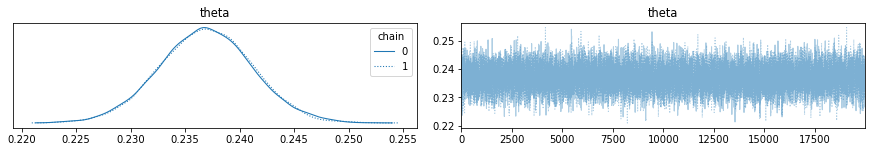

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 53 seconds.
The number of effective samples is smaller than 25% for some parameters.


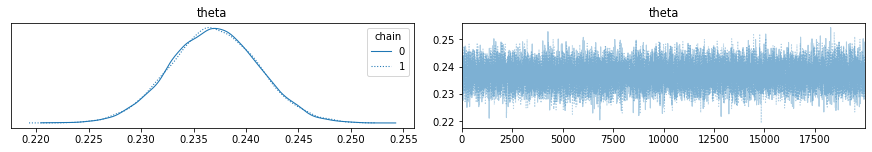

Using first concentration parameter for Model 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 135 seconds.
The number of effective samples is smaller than 25% for some parameters.


<MultiTrace: 2 chains, 10000 iterations, 2 variables>


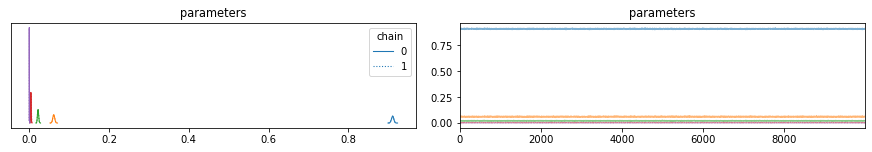

Using first concentration parameter for Model 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [parameters]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 91 seconds.


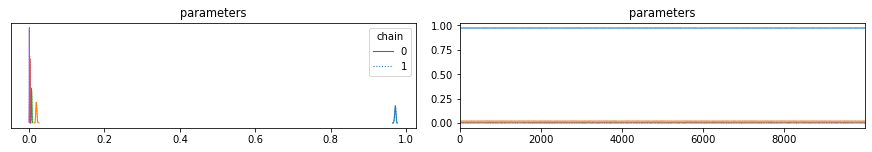

In [20]:
averaging_method = "stacking"
project_folder = "Merapi_test"
Uncertainty_schema = 1
confirmed_VEI_eruptions = VEI_count
show_trace = "True"

Model_average_stacking = get_model_average(GVP_volcanoes,
                                           volc_num,
                                           Volcano_type_1,
                                           Volcano_type_2,
                                           Observed_rate,
                                           Observed_VEI,
                                           confirmed_VEI_eruptions,
                                           Freq_rate_1,
                                           Freq_rate_2,
                                           Freq_rate_std_1,
                                           Freq_rate_std_2,
                                           VEI_freq_1,
                                           VEI_freq_2,
                                           Power_law,
                                           averaging_method,
                                           year,
                                           confirmed,
                                           method,
                                           project_folder,
                                           VEI_schema,
                                           Uncertainty_schema,
                                          show_trace)

## Frequency-magnitude estimation
The results from this process are then saved as a csv and a png file for quick viewing. The example for Merapi is shown below. 

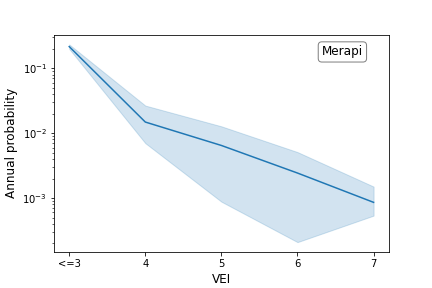

In [21]:
from IPython.display import Image
Image(filename='Figures\Merapi_test\Merapi_Certain_2019_MeadMagill50__stacking_NoPowerLaw.png') 




In [22]:
Example_Merapi_data = pd.read_csv("Probabilities\Merapi_test\Merapi_Certain_2019_MeadMagill50_stacking_NoPowerLaw.csv")
Example_Merapi_data

,Volcano Number,Volcano Name,GVP DB Year,Included eruptions,Estimate method,Change point,Average method,Power law,Probability of eruption 5th percentile,Probability of eruption 50th percentile,...,VEI 4 95th percentile,VEI 5 5th percentile,VEI 5 50th percentile,VEI 5 95th percentile,VEI 6 5th percentile,VEI 6 50th percentile,VEI 6 95th percentile,VEI 7 5th percentile,VEI 7 50th percentile,VEI 7 95th percentile
0,263250,Merapi,2019,Confirmed,Bayesian model average,MeadMagill50,stacking,False,0.204397,0.23887,...,0.026644,0.000879,0.005757,0.012758,0.000209,0.001965,0.005112,0.000536,0.000536,0.001503
